In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
from networkx.drawing.nx_pydot import graphviz_layout


rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman', 'Liberation Serif']

In [2]:
experiment_type = 'reward-network-iii-exp-v2'

In [3]:
## load data

# move_df is having one row per move
move_df = pd.read_csv(os.path.join('./data/experiment/processed/moves_w_alignment.csv'))

# TODO: add loss strategy to base csv
strategy_df = pd.read_csv(os.path.join('./data/experiment/processed/strategy_preliminary.csv'), delimiter=';')
move_df = move_df.merge(strategy_df[['session_id', 'loss_strategy']], on='session_id', how='left')

# select only demonstration trials
move_df = move_df[move_df['trial_type'] == 'demonstration']


## aggregate data

# columns to group by
index_columns = ['session_id', 'session_name', 'replication_idx', 'within_generation_idx', 'ai_player', 'generation', 'condition']

# aggregate all moves of a trial
trial_df = move_df.groupby([*index_columns, 'trial_id']).agg({'reward': 'sum', 'human_machine_match': 'mean', 'loss_strategy': 'max', 'advisor': 'first'}).reset_index()

# aggregate all trials of a player
player_df = trial_df.groupby(index_columns).agg({'reward': 'mean', 'human_machine_match': 'mean', 'loss_strategy': 'max', 'advisor': 'first'}).reset_index()


## post-process data

player_df = player_df.rename(columns={'human_machine_match': 'machine_alignment', 'reward': 'player_score'})

# add a unique id for each population
player_df['population_id'] = player_df['replication_idx'].astype(str) + ' ' + player_df['condition']

# machines do not have a strategy, we fill it with -1
player_df['loss_strategy_int'] = player_df['loss_strategy'].fillna(-1).astype(int)

# make sure that the within_generation_idx for each population starts at 0
player_df['within_generation_idx'] = player_df.groupby(['replication_idx', 'condition', 'generation'])['within_generation_idx'].rank(method='first', ascending=True) - 1

player_df = player_df.sort_values(['replication_idx', 'condition', 'within_generation_idx'])


# classify populations

# populations that have at least one player with a score above 2000 in generation 4
generation_above_threshold = (player_df.groupby(['generation', 'population_id'])['player_score'].max() > 2000).reset_index().set_index(['generation', 'player_score'])
last_gen_above_threshold = generation_above_threshold.loc[(4,True),'population_id'].tolist()
is_last_gen_above_threshold = player_df['population_id'].isin(last_gen_above_threshold)

# populations that have a machine
is_with_machine = player_df['condition'] == 'w_ai'


player_df['classification'] = 'none'
player_df.loc[is_last_gen_above_threshold & is_with_machine, 'classification'] = 'persistent'
player_df.loc[~is_last_gen_above_threshold & is_with_machine, 'classification'] = 'temporary'
player_df.loc[is_last_gen_above_threshold & ~is_with_machine, 'classification'] = 'discovered'
player_df.loc[~is_last_gen_above_threshold & ~is_with_machine, 'classification'] = 'naive'

/tmp/ipykernel_3777886/3493391799.py:46: PerformanceWarning: indexing past lexsort depth may impact performance.
  last_gen_above_threshold = generation_above_threshold.loc[(4,True),'population_id'].tolist()


## Qualitative Visualizations

In [4]:
## labels for plots

metric_name = {
    'player_score': 'performance',
    'machine_alignment': 'alignment',
    'loss_strategy': 'strategy',
    'loss_strategy_int': 'strategy'
}
binary_metrics = ['loss_strategy_int']
continues_metrics = ['player_score', 'machine_alignment']
all_metrics = continues_metrics + binary_metrics

In [5]:
color_map = {
}

for metric in continues_metrics:

    min_player_score = player_df[metric].min()
    max_player_score = player_df[metric].max()

    # Base color map
    cmap = plt.cm.get_cmap('viridis')
    
    # ## Custom color map
    # colors = ["#2312D3", "#00DF90","#FFC900",]
    # cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)
    
    cnorm = plt.Normalize(vmin=min_player_score, vmax=max_player_score)
    cpick = plt.cm.ScalarMappable(norm=cnorm, cmap=cmap)
    color_map[metric] = cpick
    

color_map['loss_strategy_int'] = {
    -1: '#BDBDBD',
    0: '#440154',
    1: '#fde725'
}

/tmp/ipykernel_3777886/2375186394.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


In [6]:
def draw_network_legend(ax, add_colors=True, node_size=200):
    G = nx.DiGraph()
    for i in range(6 if add_colors else 4):
        G.add_node(i, label=i)
    G.add_edge(2, 3)
    node_positions = {
        0: (0, 3.3),
        1: (0, 2.7),
        2: (0, 2.0),
        3: (0, 1.0),
        4: (0, 4.5),
        5: (0, 4.0)
    }
    node_shapes = {
        0: 'o',
        1: 's',
        2: 'o',
        3: 'o',
        4: 'o',
        5: 'o'
    }
    node_colors = {
        0: 'black',
        1: 'black',
        2: 'black',
        3: 'black',
        4: color_map['loss_strategy_int'][1],
        5: color_map['loss_strategy_int'][0]
    }
    node_labels = {
        0: 'Human',
        1: 'AI',
        2: 'Teacher',
        3: 'Student',
        4: 'Loss Strategy',
        5: 'No Loss Strategy'
    }


    # Draw the network
    for shape in set(node_shapes.values()):
        # Filter nodes by shape
        filtered_nodes = [node for node in G.nodes() if node_shapes[node] == shape]
        nx.draw_networkx_nodes(G, node_positions, nodelist=filtered_nodes,
                            node_color=[node_colors[node] for node in filtered_nodes],
                            node_shape=shape, node_size=node_size, ax=ax)
    nx.draw_networkx_edges(G, node_positions, edge_color='black', ax=ax)


    for pos in range(6 if add_colors else 4):
        ax.text(node_positions[pos][0] + 0.3, node_positions[pos][1], node_labels[pos], ha='left', va='center', fontsize=14)
    ax.axis('off')

def draw_population(df, ax, metric, node_size=200, explode=False):
    # Create a directed graph
    G = nx.DiGraph()
    node_colors = {}
    node_positions = {}
    node_labels = {}
    node_shapes = {}
    ax.axis('off')
    
    n_gen = df['generation'].max() + 1

    for idx, player in df.iterrows():
        session_id = str(player['session_id'])
        # Add nodes
        G.add_node(session_id, label=player['session_name'])
        # Assign color
        cpick = color_map[metric]
        if metric in binary_metrics:
            node_colors[session_id] = cpick[player[metric]]
        else:
            node_colors[session_id] = mcolors.to_hex(cpick.to_rgba(player[metric]))
        x_shift = 0
        y_shift = n_gen
        
        node_positions[session_id] = ((player['within_generation_idx'] + x_shift), (y_shift - player['generation']))
        # Add labels
        node_labels[session_id] = player['session_name']
        # Assign shapes
        node_shapes[session_id] = 's' if player['ai_player'] else 'o'

        # Add edges
        if not pd.isna(player['advisor']):
            advisor_id = str(player['advisor'])
            G.add_edge(advisor_id, str(player['session_id']))

    if explode:
        node_positions = graphviz_layout(G, prog="dot")

    # Draw the different shapes of nodes separately
    for shape in set(node_shapes.values()):
        # Filter nodes by shape
        filtered_nodes = [node for node in G.nodes() if node_shapes[node] == shape]
        nx.draw_networkx_nodes(G, node_positions, nodelist=filtered_nodes,
                            node_color=[node_colors[node] for node in filtered_nodes],
                            node_shape=shape, node_size=node_size, ax=ax)
    nx.draw_networkx_edges(G, node_positions, edge_color='black', ax=ax)


/tmp/ipykernel_3777886/1723593616.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_3777886/1723593616.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


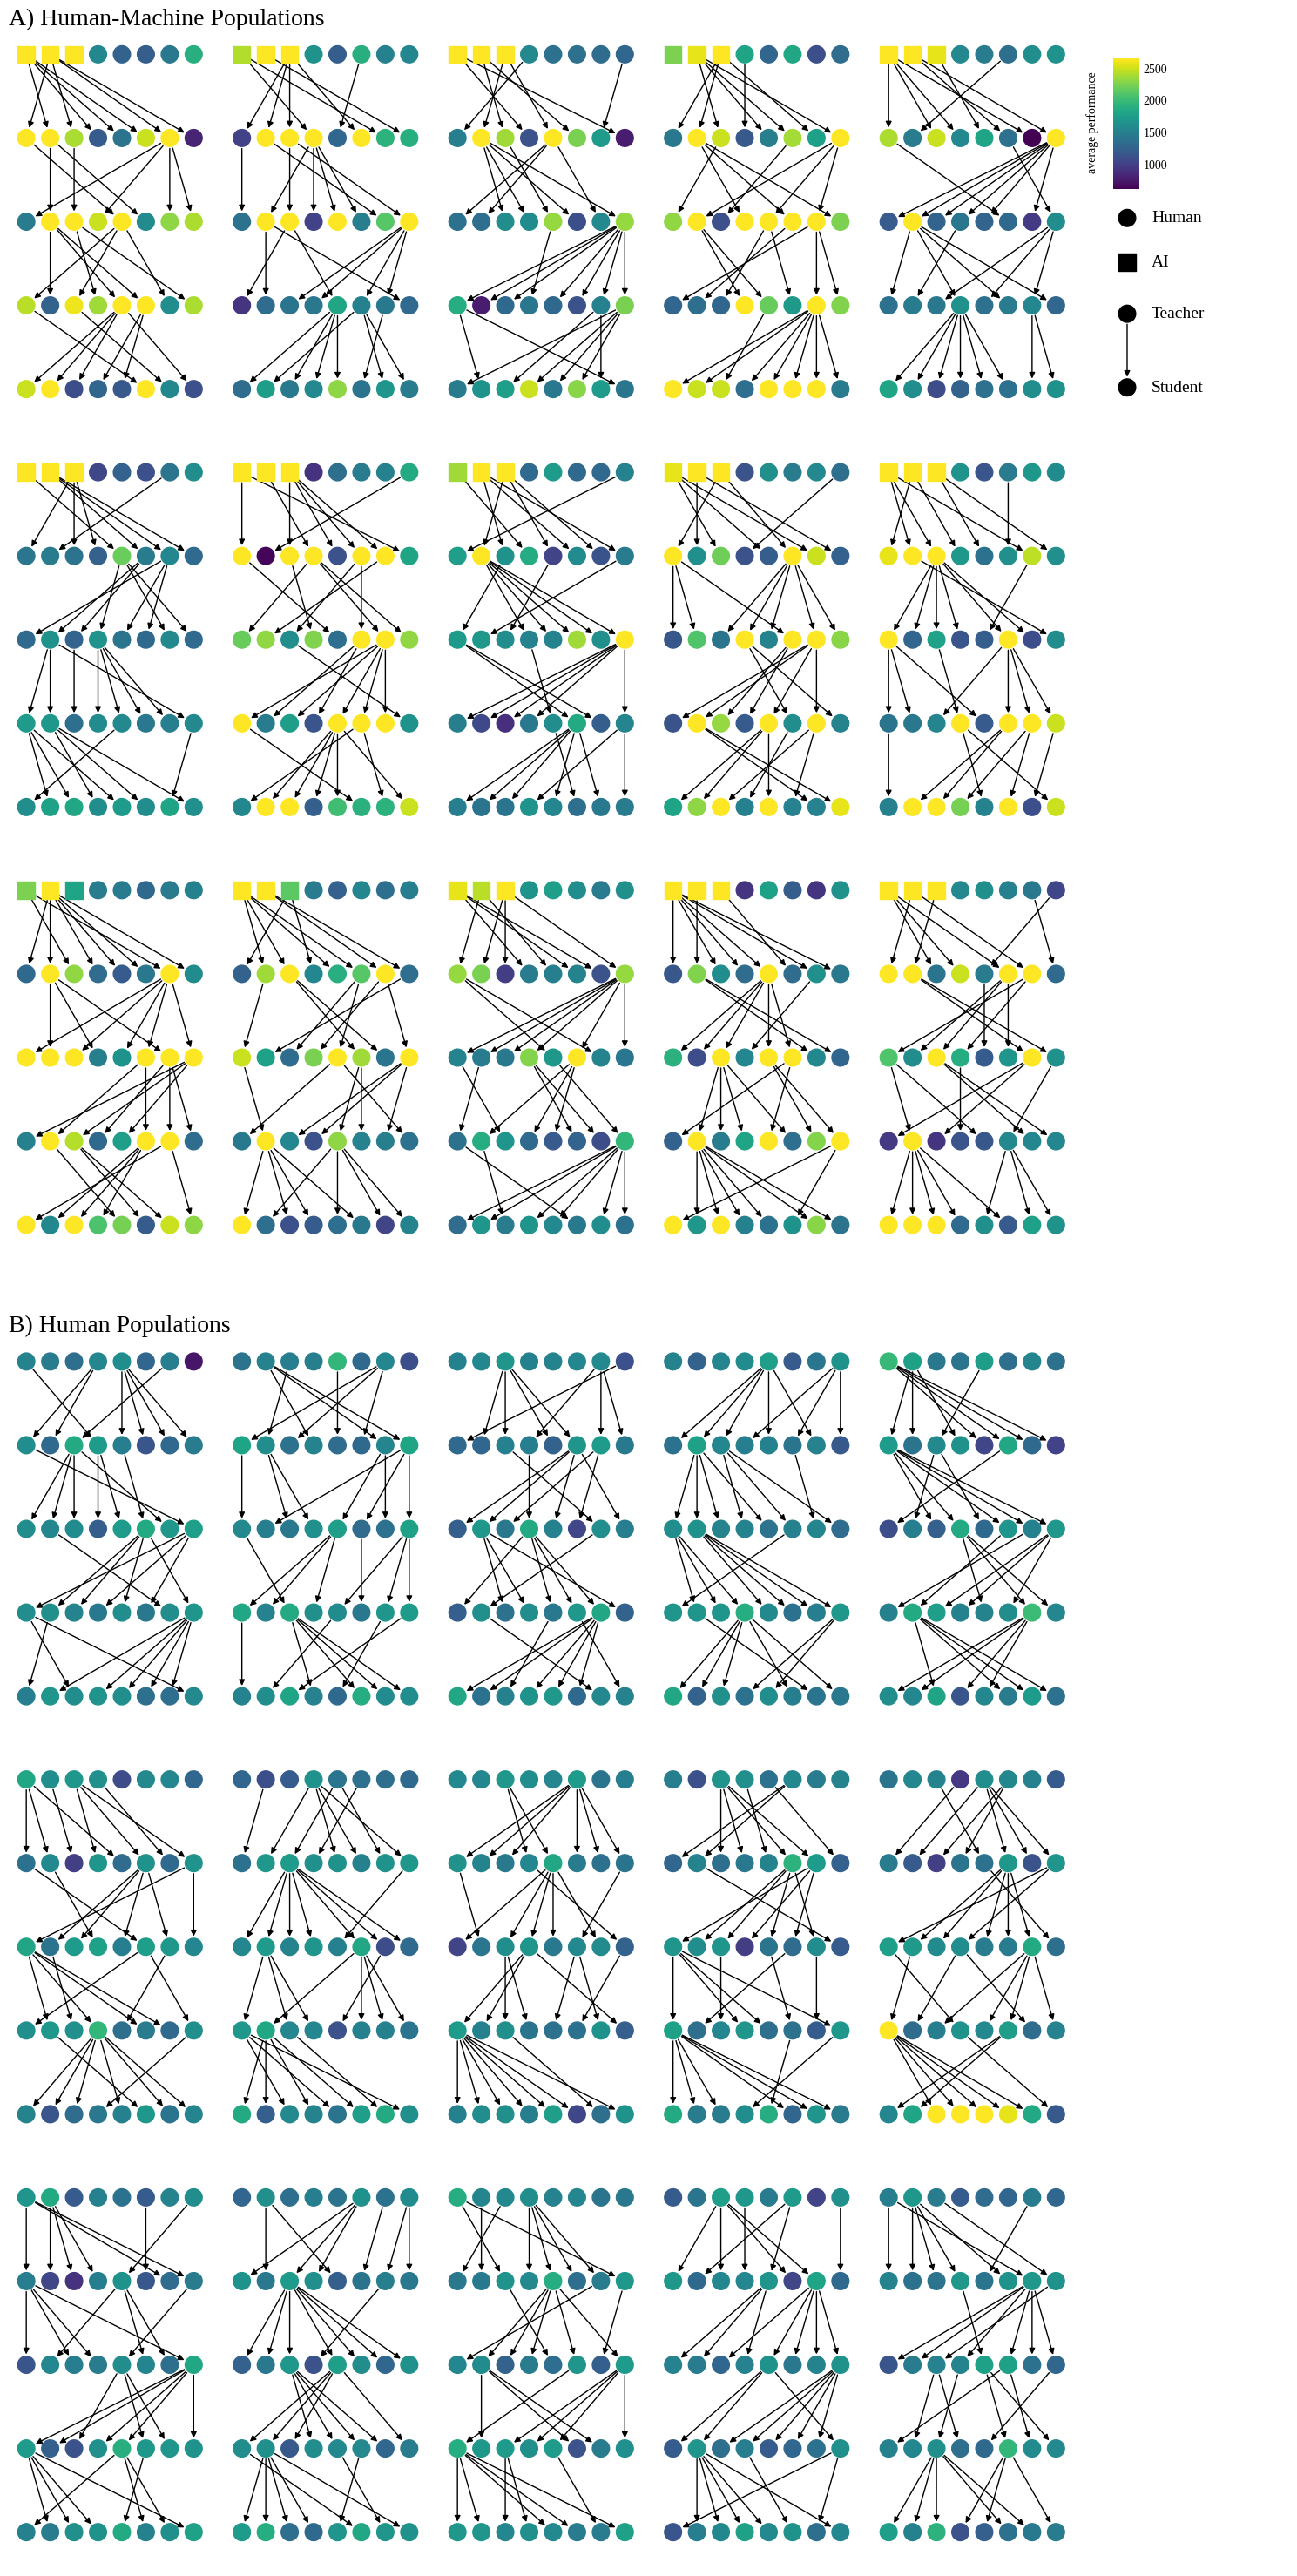

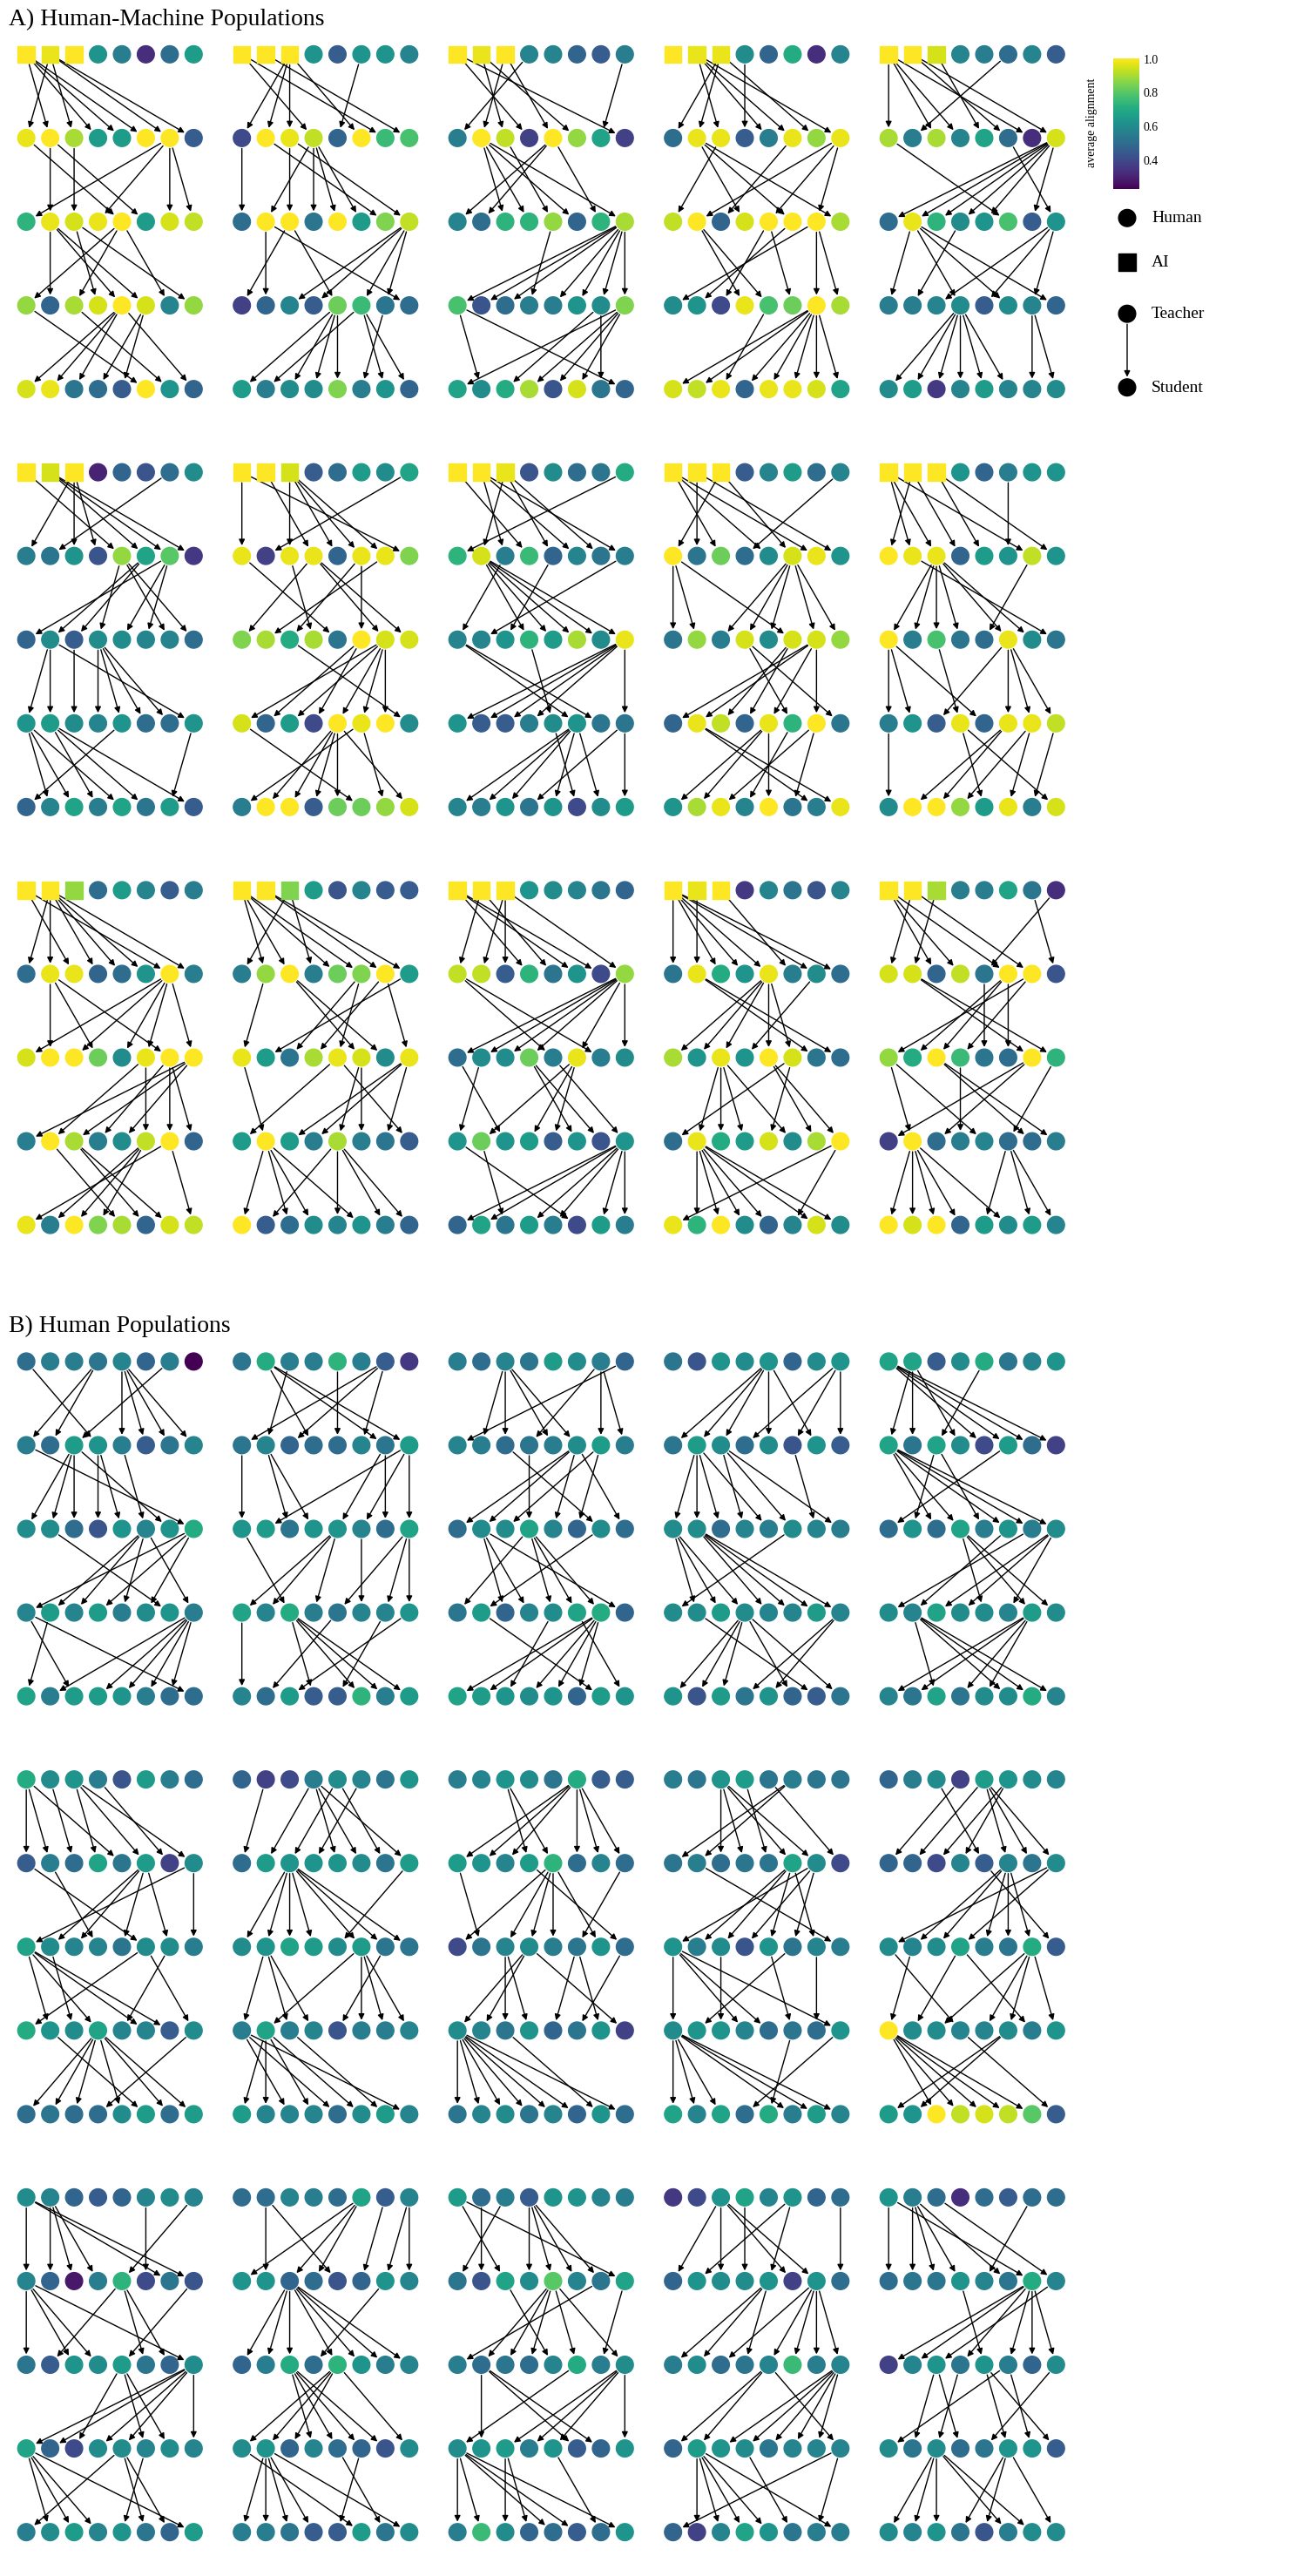

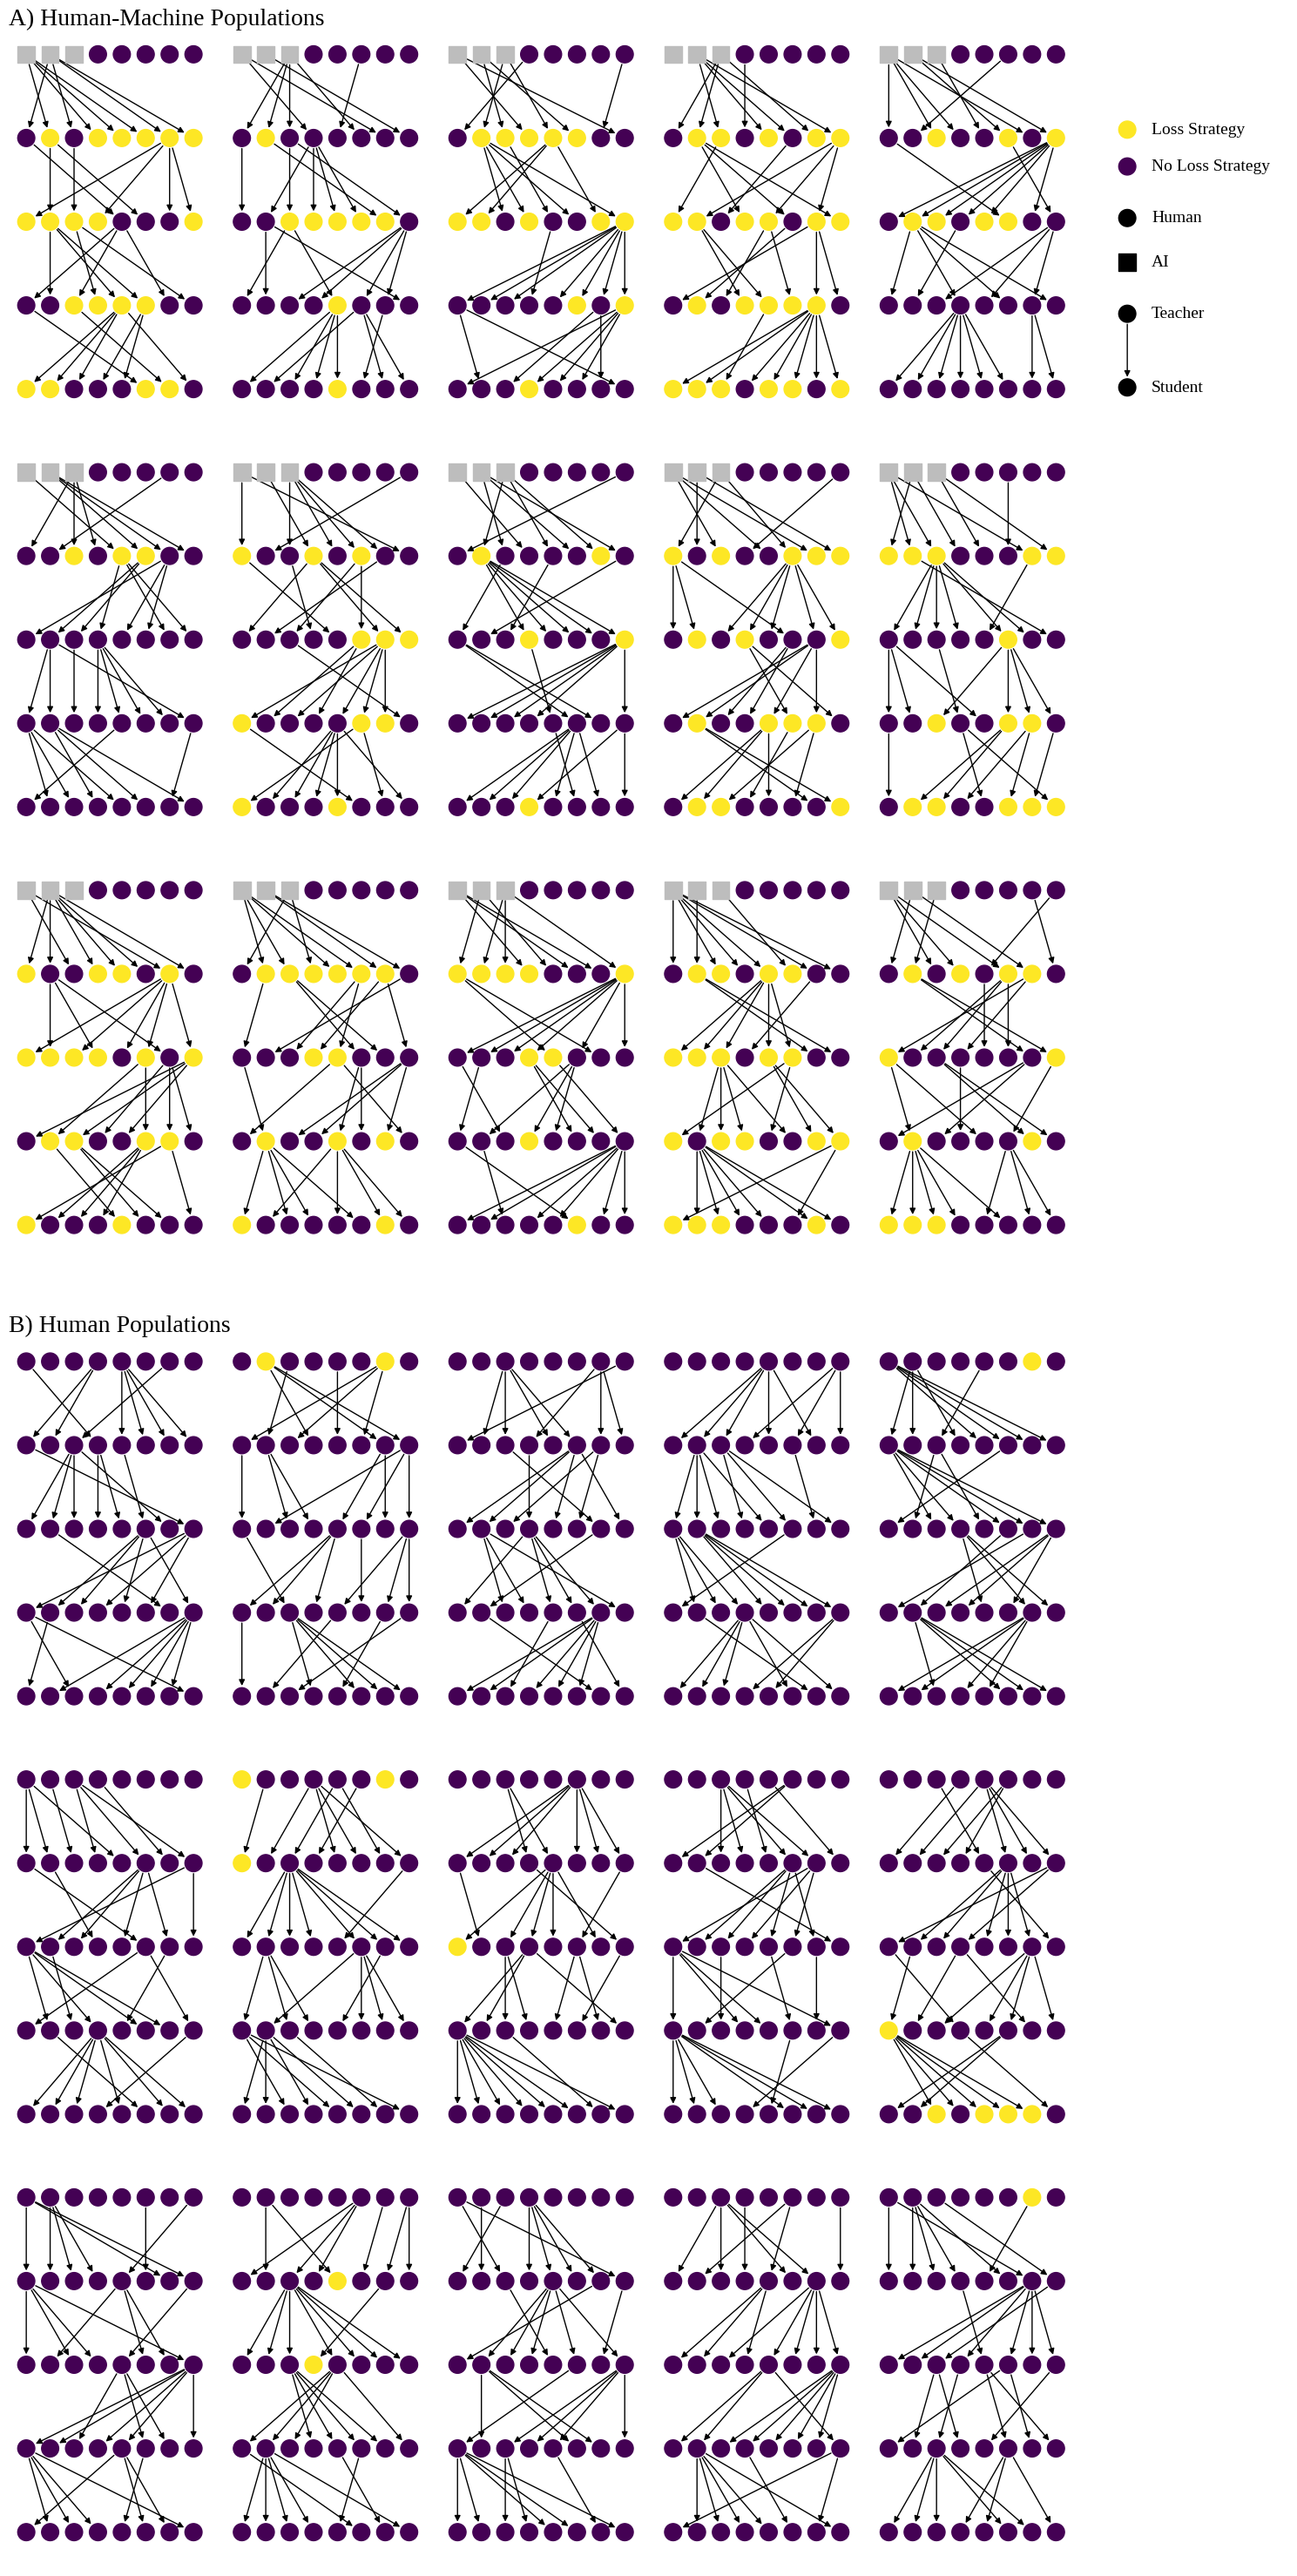

In [7]:
node_size = 200

# plot all populations
df = player_df

n_reps = df['replication_idx'].max() + 1
rows = 6
cols = n_reps // (rows // 2)

for metric in all_metrics:
    ## Set up the figure
    
    fig = plt.figure(figsize=(cols*3, rows*5))
    gs = gridspec.GridSpec(rows + 1, cols + 1, height_ratios=[1, 1, 1, 0.1, 1, 1, 1])


    ## Draw populations

    for (rep_idx, con), rep_df in df.groupby(['replication_idx', 'condition']):
        row = rep_idx // cols + (4 if con == 'wo_ai' else 0)
        col = rep_idx % cols
        ax = plt.subplot(gs[row, col])
        
        draw_population(rep_df, ax, metric, node_size=200)
        

    # Add titles
    fig.text(0.01, 0.98, 'A) Human-Machine Populations', ha='left', va='center', fontsize=20)
    fig.text(0.01, 0.48, 'B) Human Populations', ha='left', va='center', fontsize=20)


    ## Add legend
    ax = plt.subplot(gs[0, 5])
    if metric == 'loss_strategy_int':
        draw_network_legend(ax, add_colors=True)
    else:
        draw_network_legend(ax, add_colors=False)
        ax.text(-0.50, 4.6, f'average {metric_name[metric]}', ha='left', va='center', fontsize=10, rotation=90)
        cbar_ax = fig.add_axes([0.855, 0.915, 0.02, 0.05])
        cb = plt.colorbar(color_map[metric], cax=cbar_ax)
        cb.outline.set_edgecolor('none')
        cb.ax.tick_params(length=0)
    ax.set_xlim(-0.5, 2)
    ax.set_ylim(0.5, 6)

    ## Save plot
    file_name = os.path.join('plots',experiment_type,f'network_{metric}.png')
    pdf_filename = os.path.join('plots',experiment_type,f'network_{metric}.pdf')
    os.makedirs(os.path.dirname(file_name), exist_ok=True)
    plt.tight_layout()
    fig.subplots_adjust(top=0.98, right=0.99)
    plt.savefig(file_name, dpi=300, bbox_inches='tight', pad_inches=0.1)
    plt.savefig(pdf_filename, bbox_inches='tight', pad_inches=0.1)

/tmp/ipykernel_3777886/146227326.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


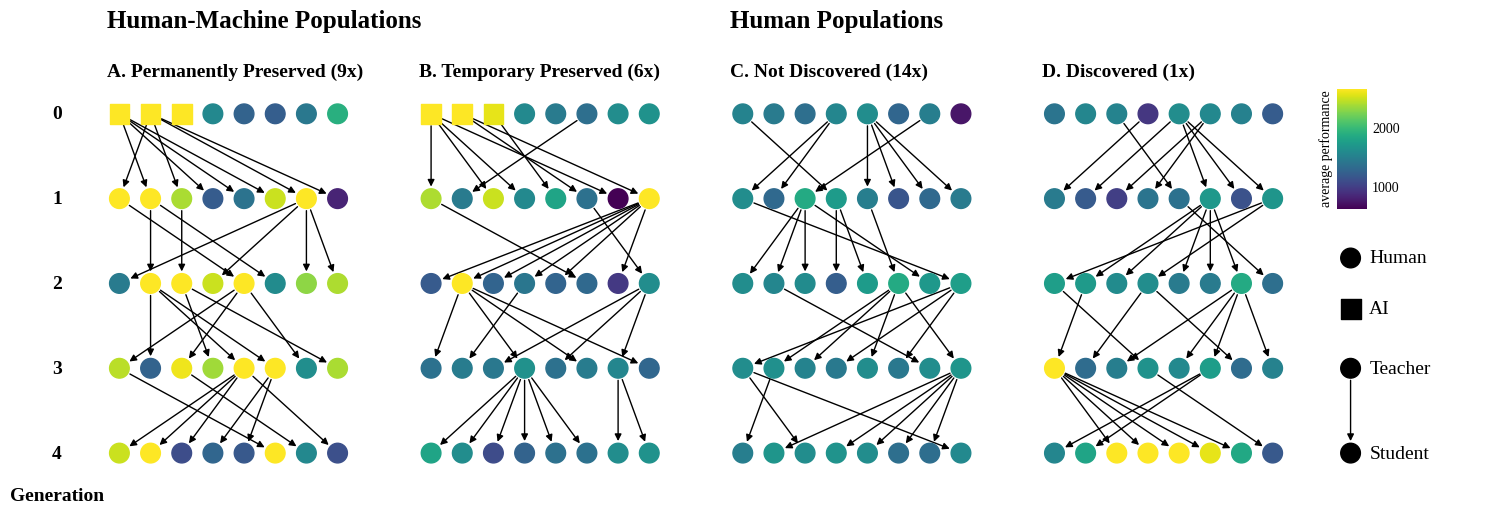

In [8]:
classes = [
    'persistent', 'temporary', 'naive', 'discovered'
]

header = {
    'persistent': 'Human-Machine Populations',
    'naive': 'Human Populations'
}


subheader = {
    'persistent': 'A. Permanently Preserved (9x)',
    'temporary': 'B. Temporary Preserved (6x)',
    'naive': 'C. Not Discovered (14x)',
    'discovered': 'D. Discovered (1x)'
}




# select the first population id for each class
class_population_id = player_df.groupby('classification')['population_id'].first().to_dict()


for metric in all_metrics:

    n_gen = player_df['generation'].max() + 1


    cols = 4
    rows = 1

    # Create figure and define GridSpec
    fig = plt.figure(figsize=((cols+1)*3, rows*5))
    gs = gridspec.GridSpec(1, 6, width_ratios=[0.1, 1, 1, 1, 1, 0.5])  # Adjust the grid layout


    for i, c in enumerate(classes):
        
        df = player_df[player_df['population_id'] == class_population_id[c]]

        row = 0
        col = i + 1

        ax = plt.subplot(gs[row, col])
        ax.axis('off')

        draw_population(df, ax, metric, node_size=200)

        ax.set_ylim(0.5, 6)
        ax.set_xlim(-1.5, 8.5)
        
        if c in header:
            ax.text(-0.4, 6.1, header[c], ha='left', va='center', fontsize=18, fontweight='bold')
        
        ax.text(-0.4, 5.5, subheader[c], ha='left', va='center', fontsize=14, fontweight='bold')


    ## Add legend
    
    ax = plt.subplot(gs[0, 5])
    if metric == 'loss_strategy_int':
        draw_network_legend(ax, add_colors=True)
    else:
        draw_network_legend(ax, add_colors=False)
        ax.text(-0.50, 4.6, f'average {metric_name[metric]}', ha='left', va='center', fontsize=10, rotation=90)
        cbar_ax = fig.add_axes([0.898, 0.62, 0.02, 0.24])
        cb = plt.colorbar(color_map[metric], cax=cbar_ax)
        cb.outline.set_edgecolor('none')
        cb.ax.tick_params(length=0)
    ax.set_xlim(-0.5, 2)
    ax.set_ylim(0.5, 6)

    ## Add generation labels
    
    ax = plt.subplot(gs[0, 0])
    ax.set_xlim(-1, 1)
    ax.set_ylim(0.5, 6)
    ax.axis('off')
    for i in range(5):
        ax.text(0, 5-i, f"{i}", ha='center', va='center', fontsize=14, fontweight='bold')
    ax.text(0, 0.5, 'Generation', ha='center', va='center', fontsize=14, fontweight='bold')

    ## Save plot

    png_filename = os.path.join('plots',experiment_type,f'network_compressed_{metric}.png')
    pdf_filename = os.path.join('plots',experiment_type,f'network_compressed_{metric}.pdf')
    os.makedirs(os.path.dirname(file_name), exist_ok=True)
    plt.tight_layout()
    fig.subplots_adjust(top=0.98, right=0.99, wspace=0.0, hspace=0.0)
    plt.savefig(png_filename, dpi=300, bbox_inches='tight', pad_inches=0.1)
    plt.savefig(pdf_filename, bbox_inches='tight', pad_inches=0.1)
    break

/tmp/ipykernel_3777886/3410831030.py:90: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which has known issues and is not actively maintained. Consider using nx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  node_positions = graphviz_layout(G, prog="dot")
/tmp/ipykernel_3777886/3410831030.py:90: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which has known issues and is not actively maintained. Consider using nx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  node_positions = graphviz_layout(G, prog="dot")
/tmp/ipykernel_3777886/3973850077.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_3777886/3410831030.py:90: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which has known issues and is not actively m

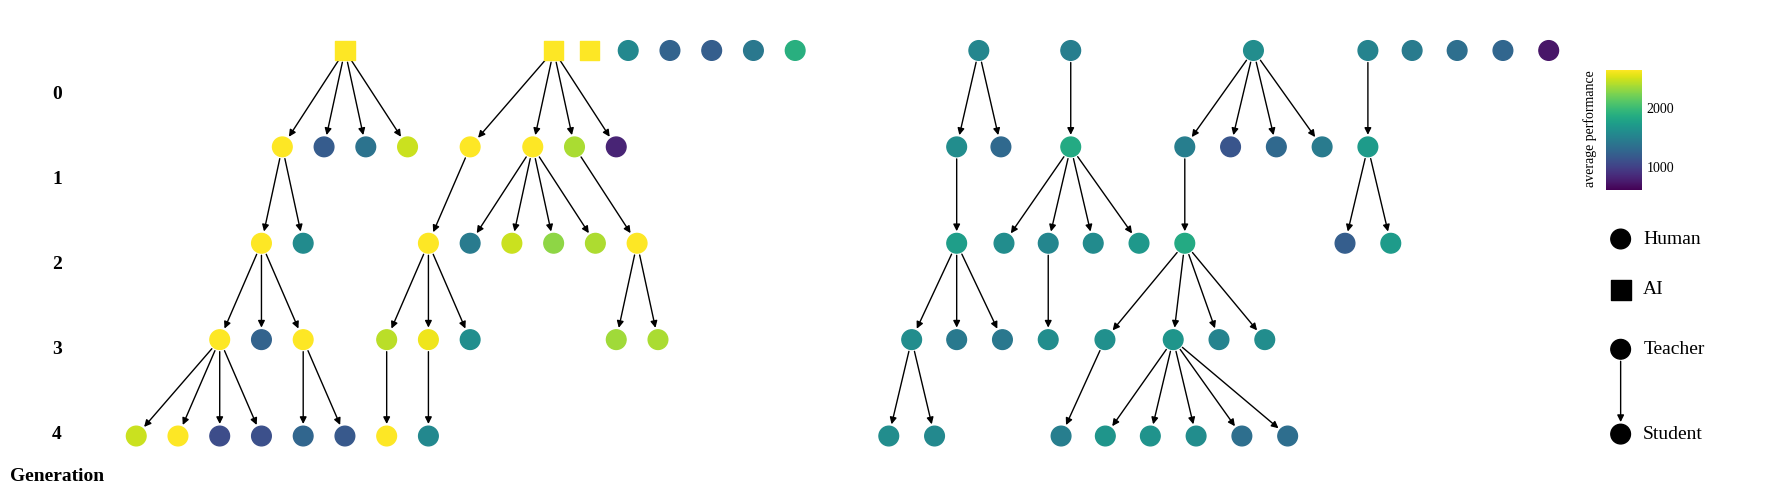

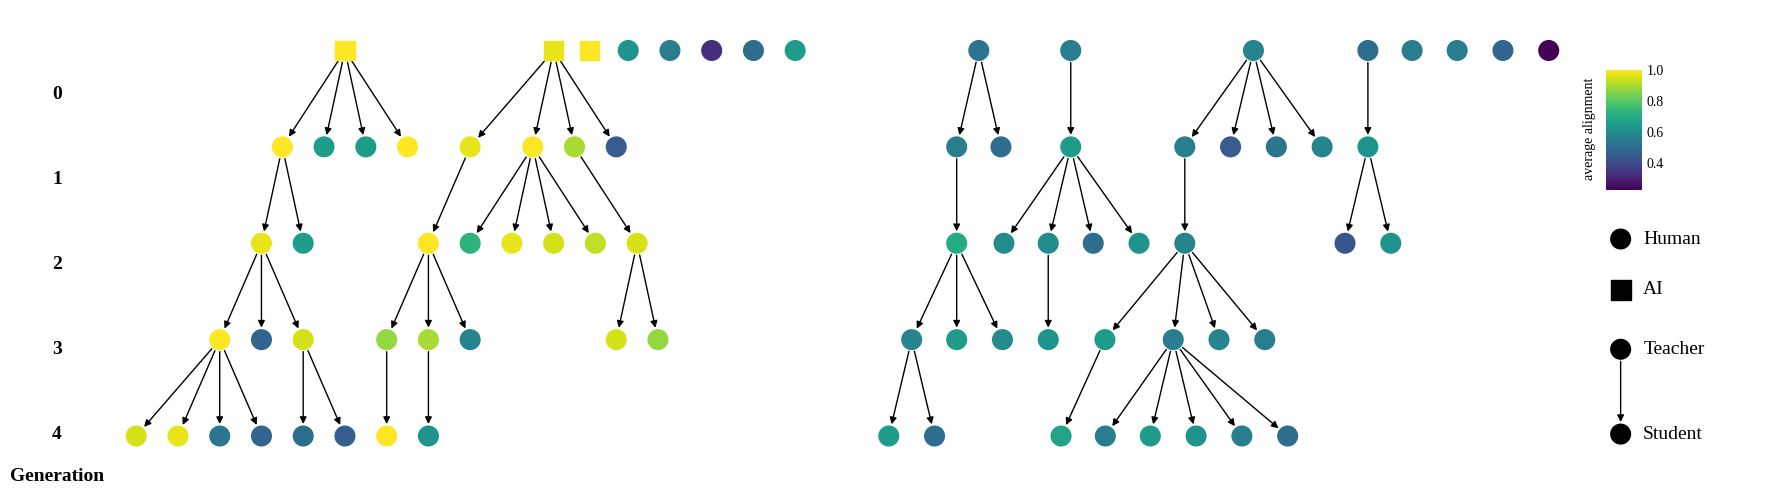

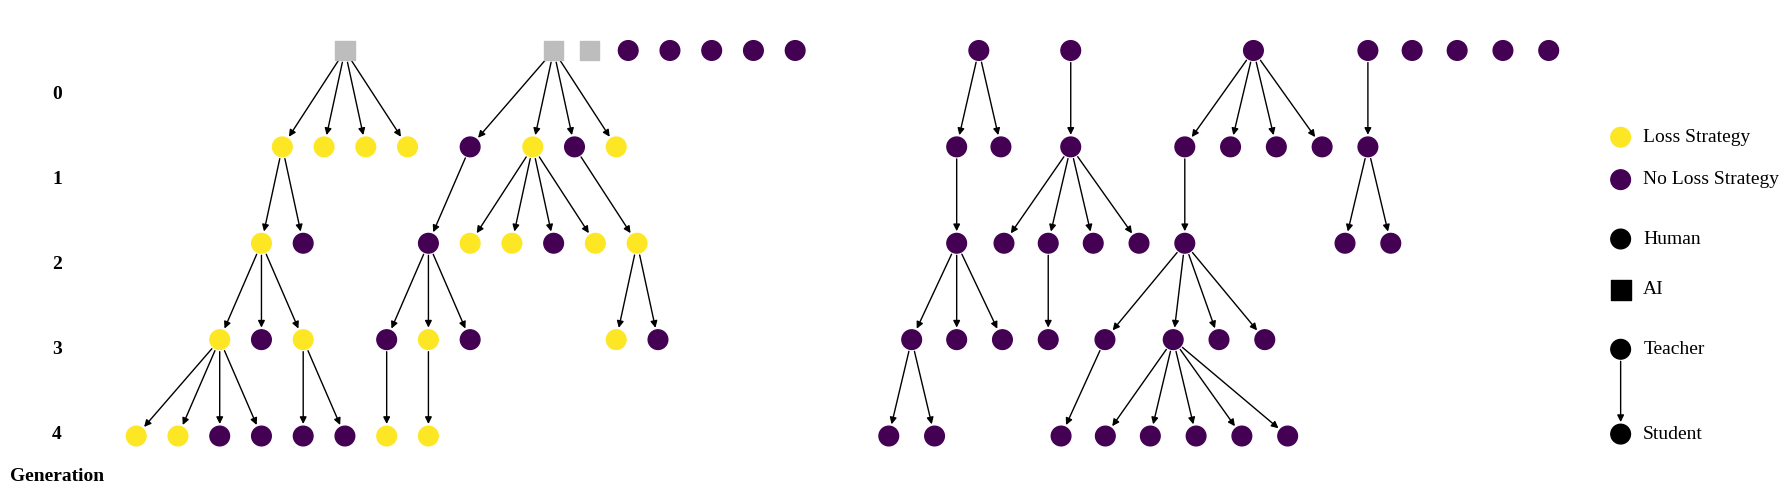

In [9]:
classes = [
    'persistent', 'naive'
]

# select the first population id for each class
class_population_id = player_df.groupby('classification')['population_id'].first().to_dict()


for metric in all_metrics:

    n_gen = player_df['generation'].max() + 1


    cols = 2
    rows = 1

    # Create figure and define GridSpec
    fig = plt.figure(figsize=((cols+1)*6, rows*5))
    gs = gridspec.GridSpec(1, cols+2, width_ratios=[0.1, 2, 2, 0.5])  # Adjust the grid layout


    for i, c in enumerate(classes):
        
        df = player_df[player_df['population_id'] == class_population_id[c]]

        row = 0
        col = i + 1

        ax = plt.subplot(gs[row, col])
        ax.axis('off')

        draw_population(df, ax, metric, node_size=200, explode=True)

        # ax.set_ylim(0.5, 6)
        # ax.set_xlim(-1.5, 8.5)


    ## Add legend
    
    ax = plt.subplot(gs[0, 3])
    if metric == 'loss_strategy_int':
        draw_network_legend(ax, add_colors=True)
    else:
        draw_network_legend(ax, add_colors=False)
        ax.text(-0.50, 4.6, f'average {metric_name[metric]}', ha='left', va='center', fontsize=10, rotation=90)
        cbar_ax = fig.add_axes([0.898, 0.62, 0.02, 0.24])
        cb = plt.colorbar(color_map[metric], cax=cbar_ax)
        cb.outline.set_edgecolor('none')
        cb.ax.tick_params(length=0)
    ax.set_xlim(-0.5, 2)
    ax.set_ylim(0.5, 6)

    ## Add generation labels
    
    ax = plt.subplot(gs[0, 0])
    ax.set_xlim(-1, 1)
    ax.set_ylim(0.5, 6)
    ax.axis('off')
    for i in range(5):
        ax.text(0, 5-i, f"{i}", ha='center', va='center', fontsize=14, fontweight='bold')
    ax.text(0, 0.5, 'Generation', ha='center', va='center', fontsize=14, fontweight='bold')

    ## Save plot

    png_filename = os.path.join('plots',experiment_type,f'network_compressed_{metric}.png')
    pdf_filename = os.path.join('plots',experiment_type,f'network_compressed_{metric}.pdf')
    os.makedirs(os.path.dirname(file_name), exist_ok=True)
    plt.tight_layout()
    fig.subplots_adjust(top=0.98, right=0.99, wspace=0.0, hspace=0.0)
    plt.savefig(png_filename, dpi=300, bbox_inches='tight', pad_inches=0.1)
    plt.savefig(pdf_filename, bbox_inches='tight', pad_inches=0.1)

## Quantitative Visualizations

/tmp/ipykernel_3777886/3227464791.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  human_df['generation_jit_pos'] = human_df['generation_pos'] + np.random.uniform(-jitter*0.5, jitter*0.5, size=len(human_df))
/tmp/ipykernel_3777886/3227464791.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  human_df[metric] = human_df[metric] + np.random.uniform(-y_jitter*0.5*diff, y_jitter*0.5*diff, size=len(human_df))
/tmp/ipykernel_3777886/3227464791.py:53: UserWarning: The palette list has more values (3) than ne

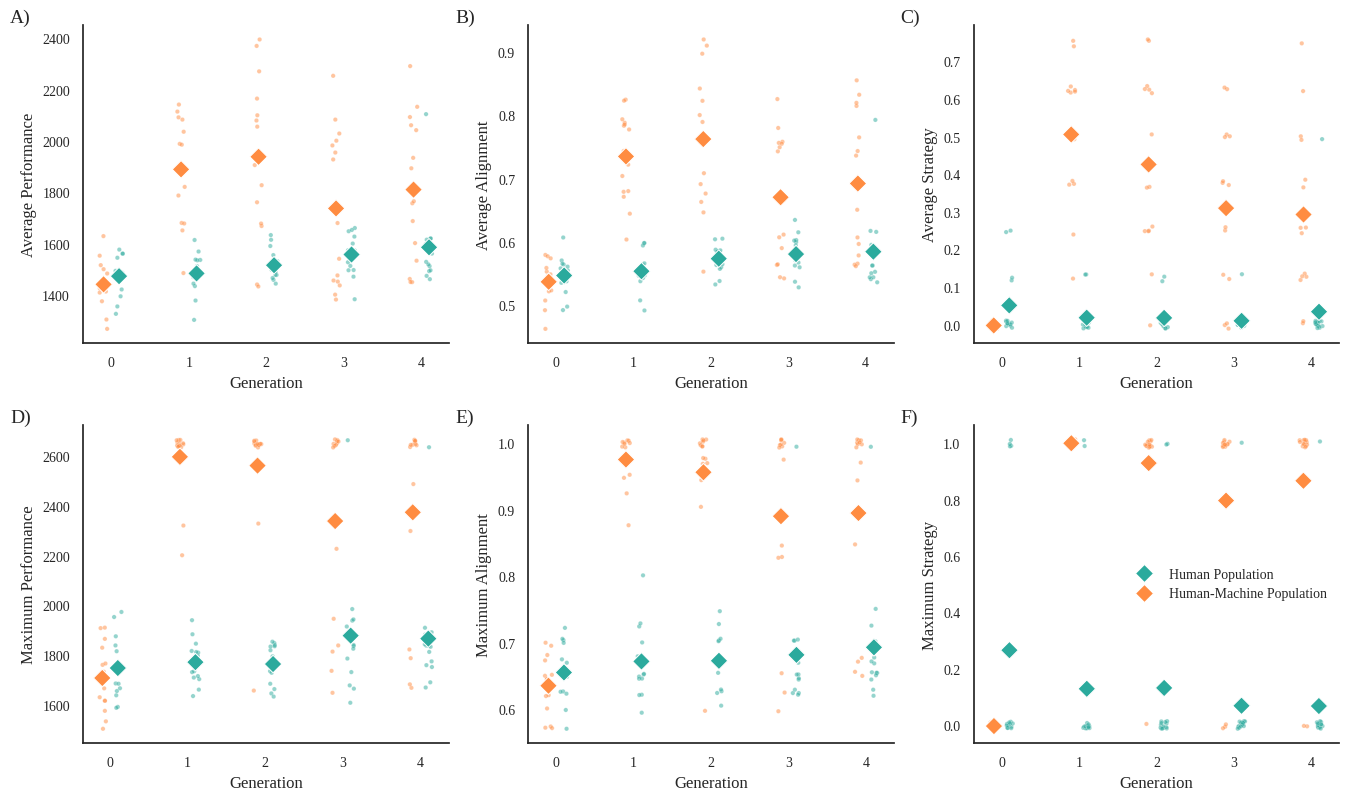

In [10]:
import seaborn as sns
import numpy as np
sns.set_theme(style='white', rc={'font.family': 'serif', 'font.serif': ['Times New Roman', 'Liberation Serif']})

legend_row_col = (1,2)
plot_machines = False
jitter = 0.1
y_jitter = 0.03
shift = 0.1
dot_size = 10

custom_palette = ['#2BAA9D', '#FF8C41', '#7F37B6', ]
hue_order = ['Human Population', 'Human-Machine Population']

df = player_df.copy()

df['generation_pos'] = df['generation'].astype(float)
# shift the positions of the populations slightly
df.loc[df['condition'] == 'w_ai', 'generation_pos'] -= shift
df.loc[df['condition'] == 'wo_ai', 'generation_pos'] += shift

# rename the conditions
df['condition_str'] = df['condition'].replace({'w_ai': 'Human-Machine Population', 'wo_ai': 'Human Population'})


cols = 3
rows = 2

fig = plt.figure(figsize=(cols*4.5, rows*4))
gs = gridspec.GridSpec(rows, cols)

for row, agg in enumerate(['mean', 'max']):
    for col, metric in enumerate(all_metrics):
        m_name = metric_name[metric]
        with_legend = legend_row_col[0] == row and legend_row_col[1] == col
        
        subplot_idx = row * cols + col
        subplot_letter = chr(65 + subplot_idx)
        
        ax = plt.subplot(gs[row, col])
        
        # aggregate the data for each generation
        generation_df = df.groupby(['replication_idx', 'generation_pos', 'condition_str', 'ai_player'])[metric].apply(agg).reset_index()

        ## plot human player
        human_df = generation_df[generation_df['ai_player'] == False]
        
        # add some jitter to the x-axis
        human_df['generation_jit_pos'] = human_df['generation_pos'] + np.random.uniform(-jitter*0.5, jitter*0.5, size=len(human_df))
        diff = human_df[metric].max() - human_df[metric].min()
        human_df[metric] = human_df[metric] + np.random.uniform(-y_jitter*0.5*diff, y_jitter*0.5*diff, size=len(human_df))
        
        sns.scatterplot(data=human_df, x='generation_jit_pos', y=metric, hue='condition_str', hue_order=hue_order, s=dot_size, alpha=0.5, ax=ax, legend=False, palette=custom_palette)

        generation_mean_df = human_df.groupby(['generation_pos', 'condition_str'])[metric].mean().reset_index()
        sns.scatterplot(data=generation_mean_df, x='generation_pos', y=metric, hue='condition_str', hue_order=hue_order, s=80, alpha=1, ax=ax, marker='D', palette=custom_palette, legend=with_legend)

        ## machine player
        if plot_machines:
            machine_df = generation_df[generation_df['ai_player'] == True]
            generation_mean_df = machine_df.groupby(['generation_pos', 'condition_str'])[metric].mean().reset_index()
            sns.scatterplot(data=generation_mean_df, x='generation_pos', y=metric, hue='condition_str', hue_order=hue_order, s=80, alpha=1, ax=ax, marker='s', palette=custom_palette, legend=False)

        ## add labels
        ax.set_xlabel('Generation', fontsize=12)
        agg_label = 'Average' if agg == 'mean' else 'Maximum'
        ax.set_ylabel(f'{agg_label} {m_name.capitalize()}', fontsize=12)


        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if with_legend:
            ax.legend(frameon=False, fontsize=10)
            
        ax.tick_params(axis='both', which='major', labelsize=10)
        
        ax.text(-0.20, 1.05, f'{subplot_letter})', ha='left', va='top', fontsize=14, transform=ax.transAxes)


png_filename = os.path.join('plots',experiment_type,f'metrics_overview.png')
pdf_filename = os.path.join('plots',experiment_type,f'metrics_overview.pdf')
os.makedirs(os.path.dirname(file_name), exist_ok=True)
plt.tight_layout()
fig.subplots_adjust(top=0.98, right=0.99)
plt.savefig(png_filename, dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.savefig(pdf_filename, bbox_inches='tight', pad_inches=0.1)

In [11]:
dfs = df.groupby(['condition', 'generation', 'population_id'])['player_score'].max().reset_index()


dfs = dfs[dfs['generation'] != 0]

dfs = dfs[dfs['player_score'] > 2000]

dfs.groupby(['condition', 'population_id'])['generation'].nunique()

condition  population_id
w_ai       0 w_ai           4
           1 w_ai           3
           10 w_ai          4
           11 w_ai          4
           12 w_ai          2
           13 w_ai          4
           14 w_ai          4
           2 w_ai           4
           3 w_ai           4
           4 w_ai           2
           5 w_ai           1
           6 w_ai           4
           7 w_ai           2
           8 w_ai           4
           9 w_ai           4
wo_ai      9 wo_ai          2
Name: generation, dtype: int64

In [12]:
df

session_id                         session_name  \
0     65d32e25dd6859254f5c592a        Rep 0 - Gen 0 - w_ai - 0 - AI   
12    65d32e25dd6859254f5c593a     Rep 0 - Gen 1 - w_ai - 0 - Human   
27    65d32e2add6859254f5c594a     Rep 0 - Gen 2 - w_ai - 0 - Human   
42    65d32e2edd6859254f5c595a     Rep 0 - Gen 3 - w_ai - 0 - Human   
57    65d32e32dd6859254f5c596a     Rep 0 - Gen 4 - w_ai - 0 - Human   
...                        ...                                  ...   
981   65d32f1ddd6859254f5c5d99  Rep 14 - Gen 0 - wo_ai - 15 - Human   
994   65d32f1edd6859254f5c5da9  Rep 14 - Gen 1 - wo_ai - 15 - Human   
1007  65d32f23dd6859254f5c5db9  Rep 14 - Gen 2 - wo_ai - 15 - Human   
1022  65d32f27dd6859254f5c5dc9  Rep 14 - Gen 3 - wo_ai - 15 - Human   
1036  65d32f2add6859254f5c5dd9  Rep 14 - Gen 4 - wo_ai - 15 - Human   

      replication_idx  within_generation_idx  ai_player  generation condition  \
0                   0                    0.0       True           0      w_ai   
12                  0                    0.0      False           1      w_ai   
27                  0                    0.0      False           2      w_ai   
42                  0                    0.0      False           3      w_ai   
57                  0                    0.0      False           4      w_ai   
...               ...                    ...        ...         ...       ...   
981                14                    7.0      False           0     wo_ai   
994                14                    7.0      False           1     wo_ai   
1007               14                    7.0      False           2     wo_ai   
1022               14                    7.0      False           3     wo_ai   
1036               14                    7.0      False           4     wo_ai   

      player_score  machine_alignment  loss_strategy  \
0           2650.0              1.000            NaN   
12          2650.0              0.975            0.0   
27          1450.0              0.725            1.0   
42          2437.5              0.875            0.0   
57          2487.5              0.950            1.0   
...            ...                ...            ...   
981         1275.0              0.500            0.0   
994         1650.0              0.575            0.0   
1007        1287.5              0.600            0.0   
1022        1575.0              0.450            0.0   
1036        1450.0              0.600            0.0   

                       advisor population_id  loss_strategy_int  \
0                         None        0 w_ai                 -1   
12    65d32e25dd6859254f5c592b        0 w_ai                  0   
27    65d32e26dd6859254f5c5940        0 w_ai                  1   
42    65d32e2bdd6859254f5c594e        0 w_ai                  0   
57    65d32e2edd6859254f5c595e        0 w_ai                  1   
...                        ...           ...                ...   
981                       None      14 wo_ai                  0   
994   65d32f1ddd6859254f5c5d94      14 wo_ai                  0   
1007  65d32f1edd6859254f5c5da8      14 wo_ai                  0   
1022  65d32f23dd6859254f5c5db6      14 wo_ai                  0   
1036  65d32f26dd6859254f5c5dc7      14 wo_ai                  0   

     classification  generation_pos             condition_str  
0        persistent            -0.1  Human-Machine Population  
12       persistent             0.9  Human-Machine Population  
27       persistent             1.9  Human-Machine Population  
42       persistent             2.9  Human-Machine Population  
57       persistent             3.9  Human-Machine Population  
...             ...             ...                       ...  
981           naive             0.1          Human Population  
994           naive             1.1          Human Population  
1007          naive             2.1          Human Population  
1022          naive             3.1          Human Population  
1036        

# Are Machines (and top Humans) starting cultural linages that spread over generations?

In [32]:
# create a mapping from session_id to advisor
student_teacher = df[['session_id', 'advisor']].set_index('session_id').to_dict()['advisor']
student_teacher = {k: v for k, v in student_teacher.items() if not pd.isna(v)}

# identify the top 3 players in each group in each generation
df['group_generation_rank'] = df.groupby(['replication_idx', 'generation', 'condition'])['player_score'].rank(method='first', ascending=False)
df['group_generation_top3'] = df['group_generation_rank'] <= 3


In [36]:
# find the ultimate teacher (start of the teacher chain)
df['ultimate_teacher'] = df['session_id']
for i in range(5):
    df['ultimate_teacher'] = df['ultimate_teacher'].map(lambda x: student_teacher.get(x, x))

df_indexed = df.set_index('session_id')

# identify the ultimate teacher as machine or human
df['ultimate_teacher_machine'] = df['ultimate_teacher'].map(lambda x: df_indexed.loc[x, 'ai_player'])
# identify the top 3 players in each group in each generation
df['ultimate_teacher_top3'] = df['ultimate_teacher'].map(lambda x: df_indexed.loc[x, 'group_generation_top3'])

In [34]:
df.groupby(['condition', 'generation'])['ultimate_teacher_machine'].mean()

condition  generation
w_ai       0             0.375000
           1             0.900000
           2             0.991667
           3             1.000000
           4             1.000000
wo_ai      0             0.000000
           1             0.000000
           2             0.000000
           3             0.000000
           4             0.000000
Name: ultimate_teacher_machine, dtype: float64

In [35]:
df.groupby(['condition', 'generation'])['ultimate_teacher_top3'].mean()

condition  generation
w_ai       0             0.375000
           1             0.900000
           2             0.991667
           3             1.000000
           4             1.000000
wo_ai      0             0.375000
           1             0.891667
           2             0.941667
           3             0.991667
           4             1.000000
Name: ultimate_teacher_top3, dtype: float64